In [2]:
import numpy as np 

import jax
import jax.numpy as jnp 
from jax import lax
from jax.numpy import einsum


import matplotlib.pyplot as plt

import scipy
from scipy.special import legendre
from scipy.special import spherical_jn 

import sys
import os
from functools import partial

from kltpicker_3d.alt_least_squares import alternating_least_squares_solver
from kltpicker_3d.tests.exp_spectrum import *
from kltpicker_3d.tests.gaussian_spectrum import * 
from kltpicker_3d.tests.rpsd_test_data import generate_gaussian_rpsd_data
from kltpicker_3d.tomogram import factorize_RPSD
from kltpicker_3d.utils import * 


jax.config.update("jax_default_device", jax.devices("cpu")[0])

plt.rcParams.update({
    "axes.grid": True,
    "grid.alpha": 0.5
})

In [3]:
def generate_uniform_radial_sampling_points(L,r_max, nbins=None):
    # Frequency lattice in cycles/pixel
    k = np.fft.fftshift(np.fft.fftfreq(L, d=1.0/(2*r_max)))      
    kx, ky, kz = np.meshgrid(k, k, k, indexing='ij')
    r = np.sqrt(kx**2 + ky**2 + kz**2)  
    eps = np.finfo(float).eps

    mask = (r <= r_max)
    r_inside = r[mask]
    r_edge = r_inside.max()
    df = 2.0 * r_max / L
    # Number of bins
    if nbins is None:
        nbins = int(max(1, np.floor(r_edge / df)))

    # Uniform-in-radius edges & centers on [0, r_max]
    r_edges = np.linspace(0.0, r_edge, nbins + 1)
    uniform_points = 0.5 * (r_edges[:-1] + r_edges[1:])

    # Indices per shell (last bin inclusive on upper edge)
    bins = []
    for j in range(nbins):
        lo, hi = r_edges[j], r_edges[j+1]
        if j < nbins - 1:
            mask = (r >= lo) & (r < hi)
        else:
            mask = (r >= lo) & (r <= hi + eps)
        bins.append(np.where(mask))

    return uniform_points, bins

N = 32 
vect_spectrum_estimation = jax.vmap(estimate_isotropic_powerspectrum_tensor,
                                    in_axes=(0,None))
max_d = int(np.floor(N/3))   

## Multiple bandlimits experiment

Q: Only confusion is the approximations and results are good when i use $\alpha c$ for $\alpha > 1$. 
Why? The signals were generated to have a sampling rate of $2*c$ to ensure the Nyquist frequency cover the support.
By using $\alpha c$ I just make the PSD slower and higher at c instead of "numerically-vanishing" outside of $[0,c]$.

In [4]:
K = 200
N = 32 
M = 2*N - 1 


bandlimits = [1,5,10]
experiments = []
true_psds = []
r_grid = []

for c in bandlimits:
    grid = np.fft.fftshift(np.fft.fftfreq(M, d=1.0/(2*c)))
    i,j,k  = np.meshgrid(grid,grid,grid)
    omega_r = np.sqrt(i**2 + j**2 + k**2)
    mask = (omega_r <= c)
    T = -np.log(1e-16)/(5*c)
    H = np.exp(-T*omega_r) * mask
    C = M ** 3 / H.sum()
    normalized_H = np.fft.ifftshift(np.sqrt(H * C))

    samples = np.zeros((K,N,N,N))
    alphas = np.random.beta(2,5,size=(K)) 
    for k in range(K):
        noise = np.random.normal(size=(M,M,M)) 
        additive_noise = np.random.normal(scale=0.1,size=(M,M,M))
        sample = np.fft.ifftn(normalized_H*np.fft.fftn(noise))
        sample = alphas[k]*sample + additive_noise
        samples[k] = sample[:N,:N,:N]

    samples = samples.real
    experiments.append(samples) 
    true_psds.append(H)

/tmp/ipykernel_2274009/1058473325.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k] = sample[:N,:N,:N]


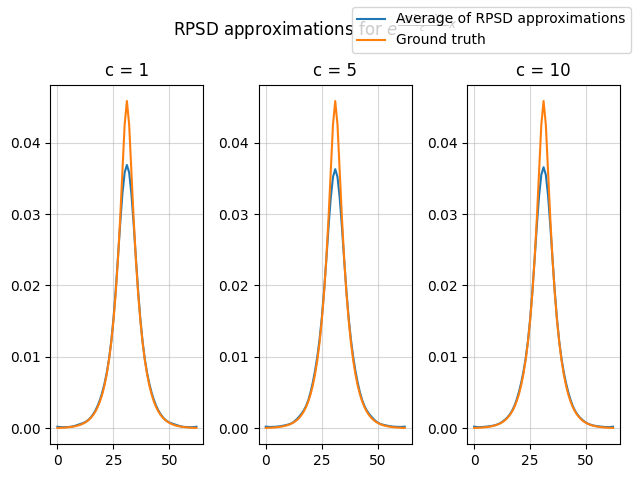

In [5]:
fig,ax = plt.subplots(1,3)

psds = []

for i,c in enumerate(bandlimits):
    samples = experiments[i] - jnp.mean(experiments[i], axis=(1,2,3)).reshape(-1,1,1,1)
    psd = vect_spectrum_estimation(samples,max_d)  
    psds.append(psd)
    
    H = true_psds[i]
    S = H / np.linalg.norm(H)
    avg_psd = np.mean(psd,axis=0)
    avg_psd /= np.linalg.norm(avg_psd)
    
    ax[i].set_title(f"c = {c}")
    ax[i].plot(avg_psd[N,N,:], label='Average of RPSD approximations')
    ax[i].plot(S[N,N,:], label='Ground truth')

fig.suptitle(r"RPSD approximations for $e^{\frac{\log( 1e-15)}{c}x}$")
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels)
fig.tight_layout()

In [6]:
def trigonometric_interpolation(x,y,z):
    n = x.shape[0]
    
    scale = (x[1] - x[0]) * n / 2 
    x_scaled = (x / scale) * jnp.pi / 2 
    z_scaled = (z / scale) * jnp.pi / 2

    delta = z_scaled[:, None] - x_scaled[None, :]
    # We take n to be only even 
    M = jnp.sin(n*delta) / (n *jnp.sin(delta))
    #if n % 2 == 0:
    #    M = np.sin(n*delta) / (n *jnp.sin(delta))
    #else:
    #    M = np.sin(n*delta)/ (n*jnp.tan(delta))
    M = M.at[jnp.isclose(delta,0)].set(1.0)

    p = M @ y 
    return p

def radial_average1(X, bins, n):
    S = np.zeros(n)
    for j in range(n):
        bin_len = bins[j][0].size
        if bin_len != 0:    
            S[j] += np.mean(X[bins[j][0]])
    return S

In [7]:
uniform_points, bins = generate_uniform_radial_sampling_points(N,c)
rblocks = np.array([radial_average1(psd[k], bins, len(bins)) for k in range(K)])
factorization = alternating_least_squares_solver(rblocks,500,1e-4)

In [8]:
rpsds = []

for i,c in enumerate(bandlimits):
    uniform_points, bins = generate_uniform_radial_sampling_points(N,c)
    rblocks = np.array([radial_average1(psds[i][k], bins, len(bins)) for k in range(K)])
    factorization = alternating_least_squares_solver(rblocks,500,1e-4)

    particle_psd = factorization.gamma
    noise_psd = factorization.v
    
    # H = true_psds[i]
    # H /= np.linalg.norm(H)
    # true_rpsd = radial_average(H,bins,N)
    # true_rpsd /= np.linalg.norm(true_rpsd)

    noise_psd /= np.linalg.norm(noise_psd)
    particle_psd /= np.linalg.norm(particle_psd)
    X,w = scipy.special.roots_legendre(150)
    X_scaled = c/2*X + c/2
    Gx = trigonometric_interpolation(uniform_points, particle_psd, X_scaled)
    Gx /= np.linalg.norm(Gx)
    rpsds.append(Gx)

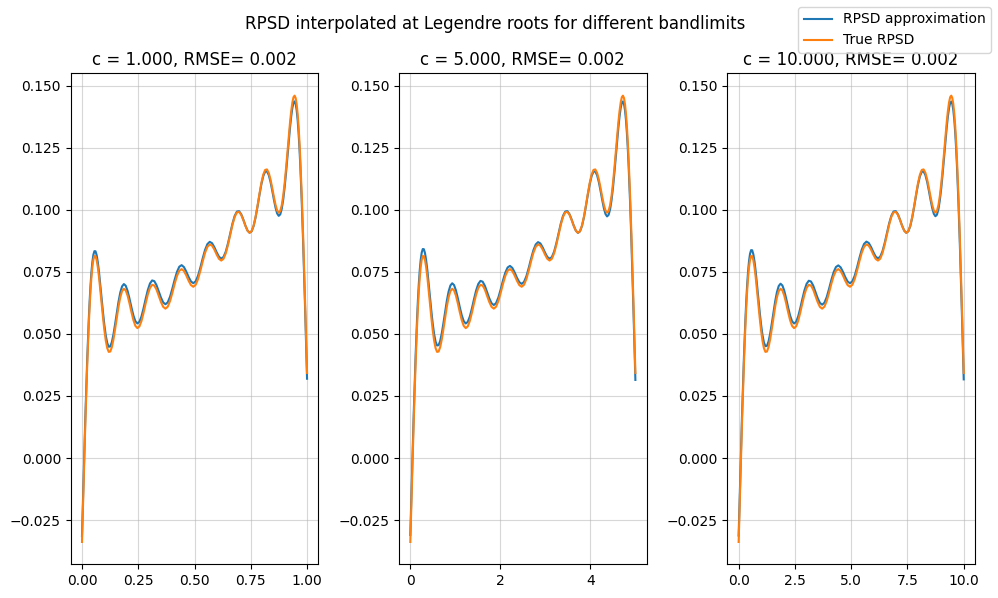

In [9]:
fig,ax = plt.subplots(1,3,figsize=(10,6))

for i,c in enumerate(bandlimits):
    X,w = scipy.special.roots_legendre(150)
    X_scaled = c/2*X + c/2
    
    uniform_points, bins = generate_uniform_radial_sampling_points(N,c)
    H = true_psds[i]
    H /= np.linalg.norm(H)
    true_rpsd = radial_average1(H,bins,len(bins))
    true_rpsd /= np.linalg.norm(true_rpsd)

    Gx_true = trigonometric_interpolation(uniform_points, true_rpsd, X_scaled)
    Gx_true /= np.linalg.norm(Gx_true)

    rmse = np.sqrt(np.mean((Gx_true - rpsds[i])**2))
    ax[i].set_title(f"c = {c:.3f}, RMSE= {rmse:.3f}")
    ax[i].plot(X_scaled,rpsds[i], label='RPSD approximation')
    ax[i].plot(X_scaled, Gx_true, label='True RPSD')


plt.suptitle("RPSD interpolated at Legendre roots for different bandlimits")
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels)
fig.tight_layout()

In [11]:
from kltpicker_3d.fredholm_solver import solve_radial_fredholm_equation

eigvals = []
for i,c in enumerate(bandlimits):
    temp = []
    for order in np.arange(5):
        eigvals_T, _, _ = solve_radial_fredholm_equation(rpsds[i],order,1,c)
        temp.append(eigvals_T)

    eigvals.append(temp)

In [12]:
eigs = np.sort(np.stack(eigvals).reshape(3,-1),axis=1)

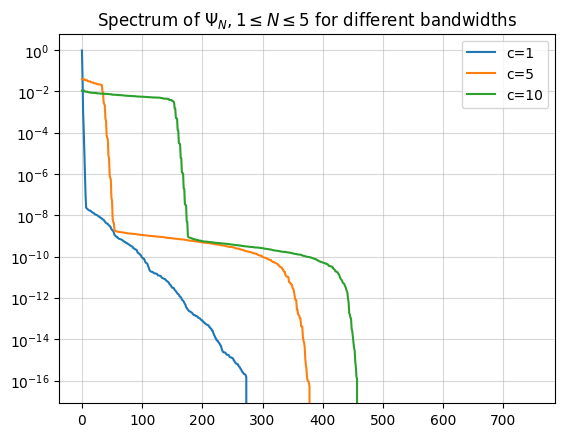

In [13]:
for i,c in enumerate(bandlimits):
    eigval = eigs[i]/np.sum(eigs[i])
    plt.plot(eigval[::-1],label=f'c={c}')

plt.title("Spectrum of $\Psi_{N}, 1\leq N \leq 5$ for different bandwidths")
plt.yscale('log')
plt.legend();

## In-depth analysis for specific bandwidth

In [16]:
K = 100
M = 2*N - 1 

c = 5
                                            
grid = np.fft.fftshift(np.fft.fftfreq(M, d=1.0/(2*c)))
i,j,k  = np.meshgrid(grid,grid,grid)
omega_r = np.sqrt(i**2 + j**2 + k**2)
mask = (omega_r <= c)

# Q: Why it works better for alpha*c for alpha > 1? It was constructed
# such that it should truncate at c 
T = -np.log(1e-16)/(5*c)
H = np.exp(-T*omega_r) * mask
C = M ** 3 / H.sum()
normalized_H = np.fft.ifftshift(np.sqrt(H * C))

samples = np.zeros((K,N,N,N))
alphas = np.random.beta(2,5,size=(K)) 
for k in range(K):
    noise = np.random.normal(size=(M,M,M))
    additive_noise = np.random.normal(scale=0.1,size=(M,M,M))
    sample = np.fft.ifftn(normalized_H*np.fft.fftn(noise))
    sample = alphas[k]*sample + additive_noise
    samples[k] = sample[:N,:N,:N]

samples = samples.real 

/tmp/ipykernel_55027/4235270894.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k] = sample[:N,:N,:N]


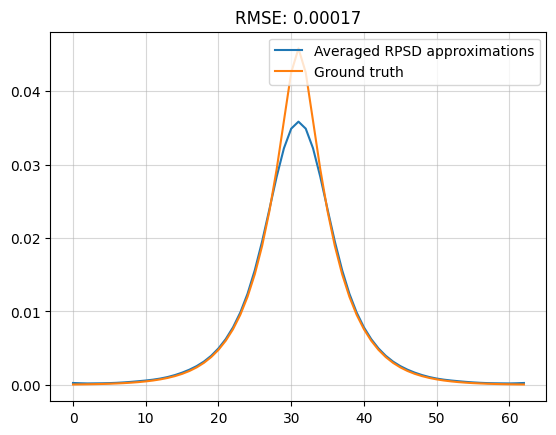

In [17]:
samples = samples - jnp.mean(samples, axis=(1,2,3)).reshape(-1,1,1,1)
psd = vect_spectrum_estimation(samples,max_d)  

S = H / np.linalg.norm(H)
avg_psd = np.mean(psd,axis=0)
avg_psd /= np.linalg.norm(avg_psd)

plt.plot(avg_psd[N,N,:], label='Averaged RPSD approximations')
plt.plot(S[N,N,:], label='Ground truth')
plt.title(f"RMSE: {np.sqrt(np.mean((avg_psd - S)**2)):.5f}")
plt.legend();

In [21]:
def trigonometric_interpolation(x,y,z):
    n = x.shape[0]
    
    scale = (x[1] - x[0]) * n / 2 
    x_scaled = (x / scale) * jnp.pi / 2 
    z_scaled = (z / scale) * jnp.pi / 2

    delta = z_scaled[:, None] - x_scaled[None, :]
    # We take n to be only even 
    M = jnp.sin(n*delta) / (n *jnp.sin(delta))
    #if n % 2 == 0:
    #    M = np.sin(n*delta) / (n *jnp.sin(delta))
    #else:
    #    M = np.sin(n*delta)/ (n*jnp.tan(delta))
    M = M.at[jnp.isclose(delta,0)].set(1.0)

    p = M @ y 
    return p

def radial_average1(X, bins, n):
    S = np.zeros(n)
    for j in range(n):
        bin_len = bins[j][0].size
        if bin_len != 0:    
            S[j] += np.mean(X[bins[j][0]])
    return S

In [22]:
uniform_points, bins = generate_uniform_radial_sampling_points(N,c)
rblocks = np.array([radial_average1(psd[k], bins, len(bins)) for k in range(K)])
factorization = alternating_least_squares_solver(rblocks,500,1e-4)

/tmp/ipykernel_39460/443847038.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,0].legend()


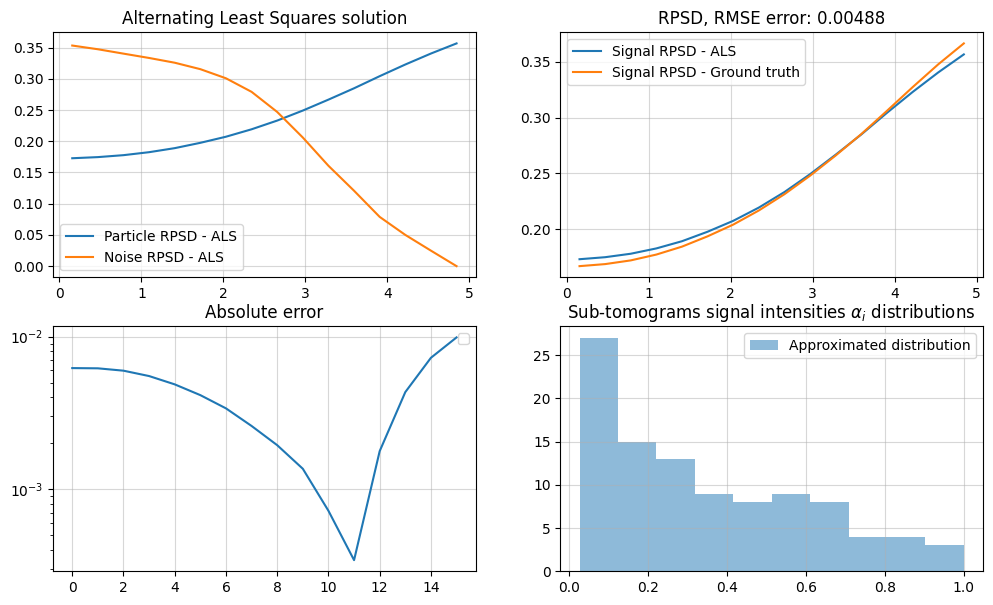

In [75]:
particle_psd = factorization.gamma
noise_psd = factorization.v

noise_psd /= np.linalg.norm(noise_psd)
particle_psd /= np.linalg.norm(particle_psd)


fig, ax = plt.subplots(2,2, figsize=(12,7))

extracted_alphas = factorization.alpha

H /= np.linalg.norm(H)

true_rpsd = radial_average1(H,bins, len(bins))
true_rpsd /= np.linalg.norm(true_rpsd)

ax[0,0].plot(uniform_points,particle_psd, label='Particle RPSD - ALS')
ax[0,0].plot(uniform_points,noise_psd, label='Noise RPSD - ALS')
ax[0,0].set_title("Alternating Least Squares solution")
ax[0,0].legend()


ax[0,1].plot(uniform_points,particle_psd,label='Signal RPSD - ALS')
ax[0,1].plot(uniform_points,true_rpsd, label='Signal RPSD - Ground truth')
#ax[0,1].set_yscale('log')
ax[0,1].set_title("RPSD benchmark")
ax[0,1].set_title(f"RPSD, RMSE error: {np.sqrt(np.mean((true_rpsd - particle_psd)**2)):.5f}")
ax[0,1].legend()

ax[1,0].set_title("Absolute error")
ax[1,0].plot(np.abs(true_rpsd - particle_psd))
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].set_title(r"Sub-tomograms signal intensities $ \alpha_i$ distributions")
ax[1,1].hist(extracted_alphas,alpha=0.5, label='Approximated distribution')
ax[1,1].legend();

Not clear to me how exactly there should be much change to the eigenvalues decay or the result as function of $c$. Note that when I extract the RPSD which is essentially the same RPSD for different c only that it's stretched further out on the interval $[0,c]$, from here I just interpolate the extracted RPSD on the same values but scaled differently.

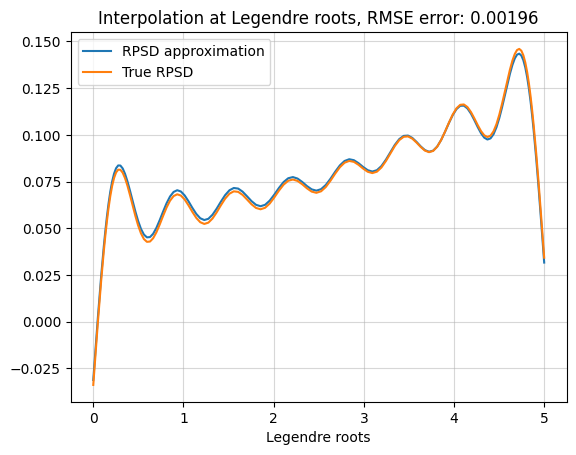

In [77]:
particle_psd = factorization.gamma
X,w = scipy.special.roots_legendre(150)
X_scaled = c/2*X + c/2
Gx = trigonometric_interpolation(uniform_points, particle_psd, X_scaled)
Gx /= np.linalg.norm(Gx)
Gx_true = trigonometric_interpolation(uniform_points, true_rpsd, X_scaled)
Gx_true /= np.linalg.norm(Gx_true)
plt.title("RPSD interpolation")
plt.plot(X_scaled, Gx, label='RPSD approximation')
plt.plot(X_scaled, Gx_true, label='True RPSD')
plt.title(f"Interpolation at Legendre roots, RMSE error: {np.sqrt(np.mean((Gx_true - Gx)**2)):.5f}")
plt.xlabel("Legendre roots")
plt.legend();

In [78]:
from scipy.special import spherical_jn 


def fredholm_solver(Gx,N,a,c,K=150):
    def Hn(x):
        return 2*np.pi * (2*(1j**N) * spherical_jn(N,x))

    X,w = scipy.special.roots_legendre(K)
    inner_rho = (c/2)*X + c/2
    outer_rho = (a/2)*X + a/2

    vv = np.array([[Hn(inner_rho[i]*inner_rho[j]) for j in range(K)] for i in range(K)])

    def psi_even(i,j):
        return c/2 * np.sum(w * vv[j,:] * vv[i,:] * Gx * (inner_rho)**2)
    
    def psi_odd(i,j):
        return c/2 * np.sum(w * (-vv[j,:]) * vv[i,:] * Gx * (inner_rho)**2)

    psi = psi_even if N % 2 == 0 else psi_odd
    H = np.array([[psi(j,i) for j in range(K)] for i in range(K)])
    W = a/2 * np.diag(w*(outer_rho)**2)
    
    # Make H symmetric for stable solution
    A = np.sqrt(W) @ H @ np.sqrt(W)    
    eigvals, Y = np.linalg.eigh(A)
    R = np.linalg.solve(np.sqrt(W), Y) 

    eigvals = eigvals[::-1]
    eigfuncs = R[:,::-1]
    return eigvals, eigfuncs, W

In [79]:
eigs = []
for order in range(10):
    eigvals, eigfuncs,W = fredholm_solver(Gx,order,1,c)
    eigs.append(eigvals)

In [80]:
eigs = np.array(eigs)

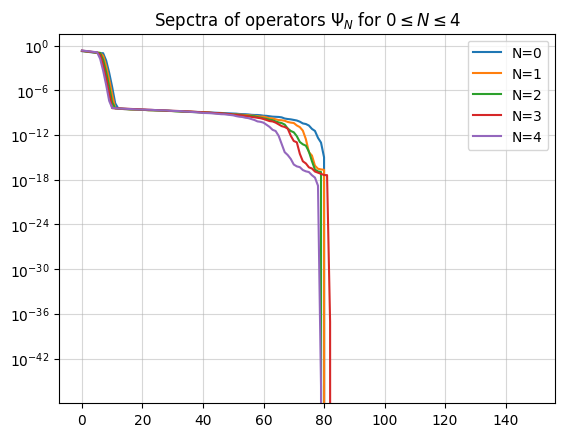

In [85]:
plt.title(r"Sepctra of operators $\Psi_N$ for $0 \leq N \leq 4$")
for i in range(5):
    plt.plot(eigs[i,:]/np.sum(eigs[i,:]), label=f"N={i}")

plt.legend();
plt.yscale('log')